as a continuation of [feature_extraction_20200523](./feature_extraction_20200523.ipynb), this notebook examines in more detail certain models, regarding convergence of recurrent computations.

as a first step, it will focus on

1. models with a high number of recurrent cycles (5,6,7)
2. models with relatively smaller cycle-to-cycle differences. "cycle-to-cycle differences" can at least be defined in two ways. I hope two definitions lead to consistent results.
    1. taking response map as a whole (N x C x D x D) and check its relative change across iterations.
    2. taking response map of each of N images, and check **average** relative change across images.

In [1]:
from os.path import dirname, relpath, realpath, join, exists

import h5py

from numpy.linalg import norm
import numpy as np

from thesis_v2 import dir_dict
from thesis_v2.submission import utils
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200523_8k_feature_extraction_generator,
    script_keygen,
    keygen,
    gen_feature_extraction_global_vars
)
from json import dump, load
from os import remove
import pandas as pd

In [2]:
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
from thesis_v2.training.training_aux import load_training_results

In [3]:
def load_all():
    
    df_this = []
    
    batch_key='yuanyuan_8k_a/20200523'
    global_vars_for_feature_extraction = gen_feature_extraction_global_vars(key=batch_key)
    
    for idx, param_dict in enumerate(explored_models_20200523_8k_feature_extraction_generator()):
        
        cls = param_dict['rcnn_bl_cls']
        # only examine 5, 6, 7
        if cls <= 4:
            continue
        
        key_this = script_keygen(**param_dict)        
        h5file = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.hdf5')
        
        
        key_for_training_result = keygen(**{k: v for k, v in param_dict.items() if k not in {'scale', 'smoothness'}})
        result = load_training_results(key_for_training_result, return_model=False)
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        auxfile = join(global_vars_for_feature_extraction['feature_file_dir'], 'diff_stats_' + key_this,
                       'test.overall.json')
        assert exists(auxfile)
        auxfile2 = join(global_vars_for_feature_extraction['feature_file_dir'], 'diff_stats_' + key_this,
                       'test.per_image.json')
        assert exists(auxfile2)
                
        with open(auxfile, 'rt', encoding='utf-8') as f_aux:
            aux_obj = load(f_aux)
            
        with open(auxfile2, 'rt', encoding='utf-8') as f_aux2:
            aux_obj2 = load(f_aux2)
        
        if idx % 100 == 0:
            print(idx)
#             print(aux_obj)
#             print(aux_obj2)


        assert param_dict['kernel_size_l23'] == 3
        if len(param_dict) == 22:
            param_dict['train_keep'] = None
        assert len(param_dict) == 23
        
        assert param_dict['kernel_size_l1'] == 9
        assert param_dict['ff_1st_block']
        
        
        
        assert param_dict['split_seed'] == 'legacy'
        assert param_dict['pooling_ksize'] == 3
        assert param_dict['pooling_type'] == 'avg'
        assert not param_dict['bn_after_fc']
        assert param_dict['rcnn_bl_psize'] == 1
        assert param_dict['rcnn_bl_ptype'] is None
        assert param_dict['input_size'] == 50
        assert param_dict['rcnn_acc_type'] == 'cummean'

        if param_dict['train_keep'] is None:
            param_dict['train_keep'] = 5120

        index_base = {
            'train_keep': param_dict['train_keep'],
            'act_fn': param_dict['act_fn'],
            'loss_type': param_dict['loss_type'],
            'scale': float(param_dict['scale']),
            'smoothness': float(param_dict['smoothness']),
            'num_layer': param_dict['num_layer'],
            'out_channel': param_dict['out_channel'],
            # 4 to go.
            '1st_bn_before_act': param_dict['ff_1st_bn_before_act'],
            'rcnn_bl_cls': param_dict['rcnn_bl_cls'],

            'model_seed': param_dict['model_seed'],
        }
        
        
        df_this.append({**index_base, **{
            'acc_mode': 'instant',
            'diff_overall': aux_obj['diff_bl_stack_instant']['raw'],
            'diff_per_image_mean': aux_obj2['diff_bl_stack_instant']['mean'],
            'diff_per_image_std': aux_obj2['diff_bl_stack_instant']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
            'key_for_training_result': key_for_training_result,
        }})
        
        df_this.append({**index_base, **{
            'acc_mode': 'cummean',
            'diff_overall': aux_obj['diff_bl_stack_cummean']['raw'],
            'diff_per_image_mean': aux_obj2['diff_bl_stack_cummean']['mean'],
            'diff_per_image_std': aux_obj2['diff_bl_stack_cummean']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
            'key_for_training_result': key_for_training_result,
        }})
    
    index_keys = list(index_base.keys()) + ['acc_mode',]
    
    df_this = pd.DataFrame(
        data=df_this,
        columns=index_keys + ['diff_overall', 'diff_per_image_mean', 'diff_per_image_std', 'corr_test', 'h5file', 'key_for_training_result']
    ).set_index(keys=index_keys, verify_integrity=True)
    return df_this
df_all = load_all()

1200
1300
1400
1500
1600
1700
1800
1900
2000


In [4]:
df_all_cp = df_all.copy(deep=True)

In [5]:
df_all_cp['mean_diff_overall'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_overall']))
df_all_cp['mean_diff_per_image'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_per_image_mean']))
df_all_cp['mean_diff_overall_first4'] = df_all.apply(axis=1, func=lambda x: np.mean(x['diff_overall'][:4]))

In [6]:
from scipy.stats import pearsonr

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    assert x.shape == y.shape == (x.size,)
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('N', x.size)
    print('x mean', x.mean(), 'std', x.std())
    print('y mean', y.mean(), 'std', y.std())
#     print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
#     print('y top', y.max(), 'x top', x.max())

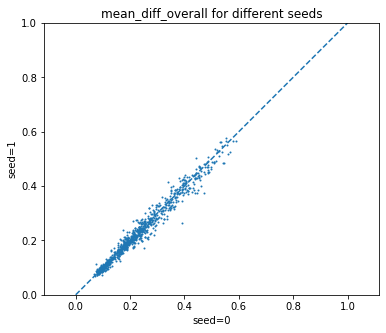

N 864
x mean 0.22959670677298197 std 0.1172371610941446
y mean 0.22741747489141553 std 0.1151262219747307
(0.9860095505726324, 0.0)


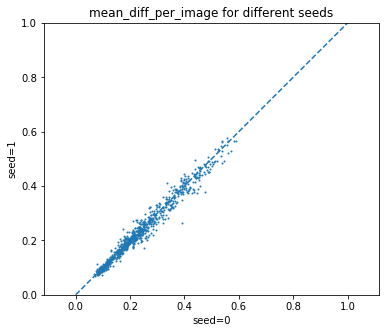

N 864
x mean 0.2297059555703349 std 0.1175209568061918
y mean 0.2276182522294148 std 0.1154739625626832
(0.9864505707246287, 0.0)


In [9]:
# almost the same.
def check_similarity_across_seeds():
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_overall'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_overall for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_per_image'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_per_image for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
check_similarity_across_seeds()

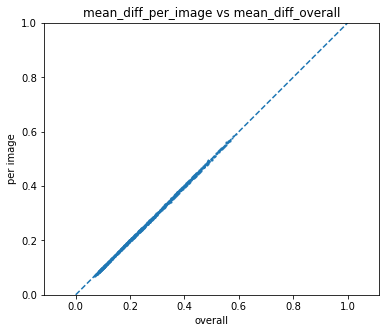

N 1728
x mean 0.22850709083219875 std 0.11619159490553994
y mean 0.22866210389987482 std 0.11650663193825193
(0.9998814676125118, 0.0)


In [10]:
# check consistency between mean_diff_overall and mean_diff_per_image

def check_consistency_between_diff_overall_and_per_image():
    
    val1 = df_all_cp['mean_diff_overall'].values
    val2 = df_all_cp['mean_diff_per_image'].values
    scatter(val1, val2, 'overall', 'per image', 'mean_diff_per_image vs mean_diff_overall')
    print(pearsonr(val1, val2))
    
# almost the same.
check_consistency_between_diff_overall_and_per_image()

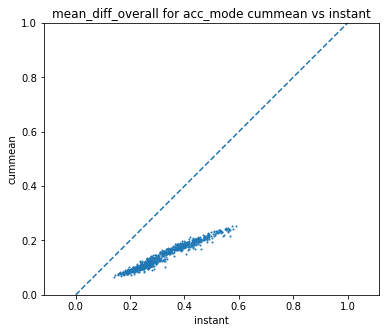

N 864
x mean 0.3162154255485174 std 0.09797942763828746
y mean 0.14079875611588014 std 0.04489433433786744
(0.9772938715441427, 0.0)


In [11]:
def check_consistency_between_instant_and_cummean():
    
    val1 = df_all_cp['mean_diff_overall'].xs('instant', level='acc_mode').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'instant', 'cummean', 'mean_diff_overall for acc_mode cummean vs instant')
    print(pearsonr(val1.values, val2.values))
    
# pretty consistent. let's use cummean for prettier results
check_consistency_between_instant_and_cummean()

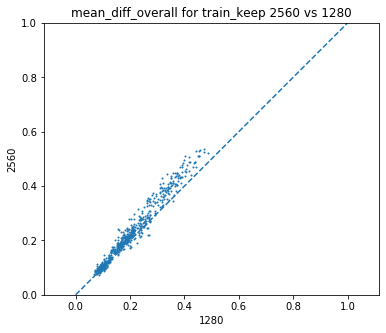

N 576
x mean 0.20531582189260345 std 0.0973592111549823
y mean 0.23063397405419017 std 0.1148061322132442
(0.983575093973038, 0.0)


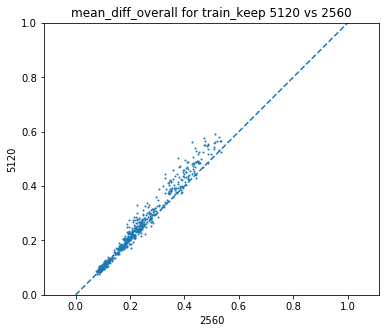

N 576
x mean 0.23063397405419017 std 0.1148061322132442
y mean 0.24957147654980266 std 0.12983115672543832
(0.9869960935922232, 0.0)


In [12]:
# check relationship to training size
def check_diff_overall_over_train_keep():
    
    val1 = df_all_cp['mean_diff_overall'].xs(1280, level='train_keep').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs(2560, level='train_keep').sort_index()
    val3 = df_all_cp['mean_diff_overall'].xs(5120, level='train_keep').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '1280', '2560', 'mean_diff_overall for train_keep 2560 vs 1280')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '2560', '5120', 'mean_diff_overall for train_keep 5120 vs 2560')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_train_keep()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

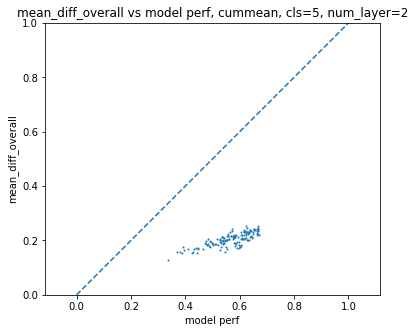

N 144
x mean 0.5661831530056222 std 0.07369466260983196
y mean 0.20466670078328913 std 0.025049026904056974
(0.7962205909438116, 8.554433117920926e-33)


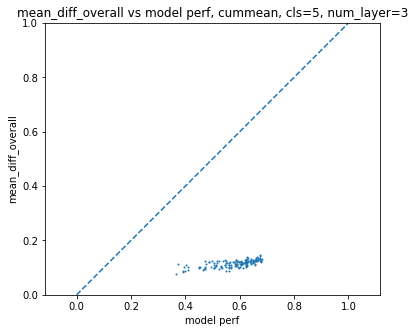

N 144
x mean 0.5781167678851149 std 0.076162403646722
y mean 0.11496719935288031 std 0.012993795545445141
(0.6816524623840899, 5.264280899249671e-21)


In [13]:
def check_relationship_between_diff_and_performance(*, num_layer, cls):
    val1 = df_all_cp['corr_test'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'model perf', 'mean_diff_overall', f'mean_diff_overall vs model perf, cummean, cls={cls}, num_layer={num_layer}')
    print(pearsonr(val1.values, val2.values))
    
check_relationship_between_diff_and_performance(num_layer=2, cls=5)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=5)

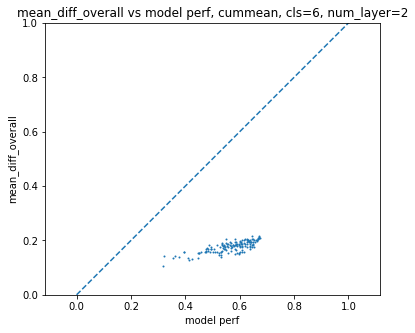

N 144
x mean 0.5659704430162767 std 0.07743248496948314
y mean 0.17724429276875325 std 0.020604286479776145
(0.772413476520901, 8.723443582048796e-30)


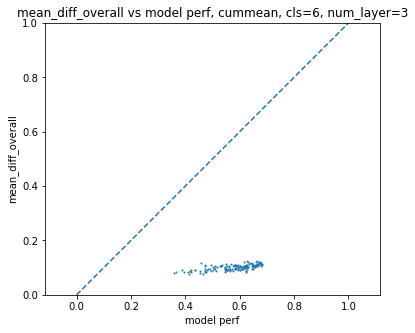

N 144
x mean 0.5770308270399309 std 0.07720237593885722
y mean 0.10123038317801224 std 0.010424868801178155
(0.6447254962965987, 2.780956624597794e-18)


In [14]:
check_relationship_between_diff_and_performance(num_layer=2, cls=6)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=6)

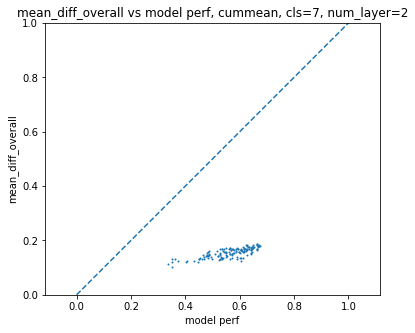

N 144
x mean 0.5654821739842547 std 0.07738153952367496
y mean 0.1557543614266992 std 0.017974619692066332
(0.7739494828580578, 5.724554545049528e-30)


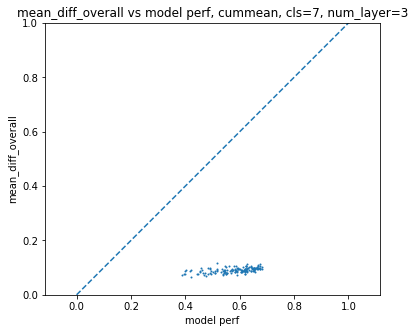

N 144
x mean 0.5781011550253319 std 0.07424714314259612
y mean 0.09092959918564669 std 0.00946011075711055
(0.5300868910327075, 8.343879933858523e-12)


In [15]:
check_relationship_between_diff_and_performance(num_layer=2, cls=7)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=7)

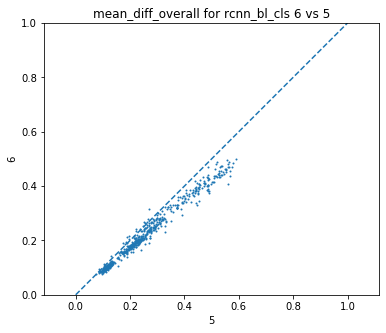

N 576
x mean 0.2585890819286255 std 0.13018780307085295
y mean 0.2258312584366649 std 0.11089440140029205
(0.989638118391144, 0.0)


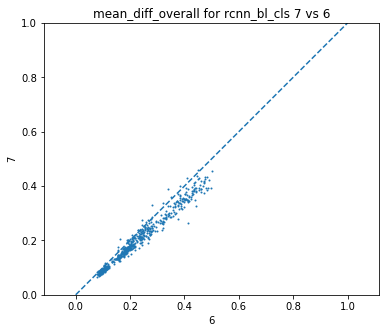

N 576
x mean 0.2258312584366649 std 0.11089440140029205
y mean 0.2011009321313058 std 0.09793796019757606
(0.9851021042159724, 0.0)


In [16]:
# relationship with cls
def check_diff_overall_over_cls(first4=False):
    field_to_check = 'mean_diff_overall' if not first4 else 'mean_diff_overall_first4'
    val1 = df_all_cp[field_to_check].xs(5, level='rcnn_bl_cls').sort_index()
    val2 = df_all_cp[field_to_check].xs(6, level='rcnn_bl_cls').sort_index()
    val3 = df_all_cp[field_to_check].xs(7, level='rcnn_bl_cls').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '5', '6', f'{field_to_check} for rcnn_bl_cls 6 vs 5')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '6', '7', f'{field_to_check} for rcnn_bl_cls 7 vs 6')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_cls()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

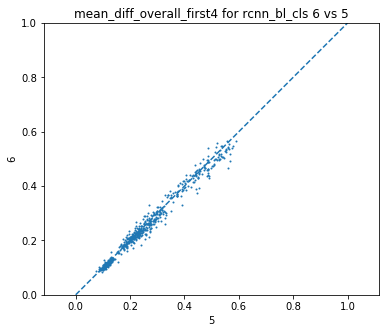

N 576
x mean 0.2585890819286255 std 0.13018780307085295
y mean 0.25498611326394083 std 0.12682452553954757
(0.9905614018755325, 0.0)


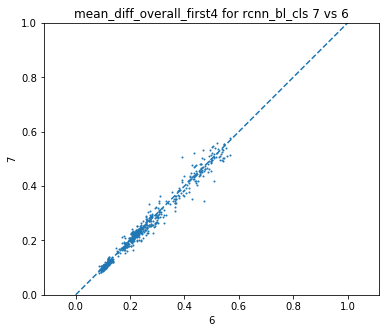

N 576
x mean 0.25498611326394083 std 0.12682452553954757
y mean 0.25282244650103775 std 0.12603613894804624
(0.9883208457829221, 0.0)


In [17]:
# always take time to drop. running more iterations won't make convergence quicker.
check_diff_overall_over_cls(True)

In [18]:
# so, let's study cls=7, cummean models

# which training size? study both 1280 and 5120

# maybe do a mean pooling first, to make vector shorter. also, the pooling version is what's actually used in fully connected layer.
from torch.nn.functional import avg_pool2d
import torch
def transform_data_all_epochs(tensor_list):
    z_shape = None
    for z in tensor_list:
        assert z.ndim == 4
        
#         print(z.shape)
    pooled_version = [avg_pool2d(torch.tensor(x), kernel_size=3).numpy() for x in tensor_list]
    for zz in pooled_version:
        # this is needed (to be consistent with 1D->4D reshape in later cells) to make
        # sure I can get back the 4D version.
#         print(zz.dtype)
        assert zz.flags['CARRAY']
        if z_shape is None:
            z_shape = zz.shape
        assert z_shape == zz.shape
        
    # then reshape . just concatenate them to do PCA/tSNE, etc.
    # z_shape is used for computing MSE loss.
    return [x.reshape(x.shape[0], -1) for x in pooled_version], z_shape


In [19]:
df_all_cp_to_study = df_all_cp.xs(0, level='model_seed').xs(5, level='rcnn_bl_cls').xs('cummean', level='acc_mode')

In [20]:
df_all_cp_to_study.iloc[0]

diff_overall                [0.31652382016181946, 0.15706120431423187, 0.1...
diff_per_image_mean         [0.31729243624955417, 0.15845310454256833, 0.1...
diff_per_image_std          [0.023491408817200552, 0.019388902360123184, 0...
corr_test                                                            0.409355
h5file                      /home/yimengzh/thesis-v2-large-files/maskcnn_p...
key_for_training_result     yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_...
mean_diff_overall                                                    0.166708
mean_diff_per_image                                                  0.167297
mean_diff_overall_first4                                             0.166708
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, True), dtype: object

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
import torch
from torch import nn

In [23]:
from torchnetjson.builder import build_net
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules
load_modules()


In [24]:
# https://stackoverflow.com/questions/44230635/avoid-overflow-with-softplus-function-in-python
# 20 matches what's in pytorch.
def safe_softplus(x, limit=20):
    return np.where(x > limit, x, np.log1p(np.exp(x)))

In [25]:
from thesis_v2.training_extra.init import inv_softplus

In [26]:
def get_inverted_resp(*, mean_response, init_type):
    assert np.all(mean_response >= 0)
    # from thesis_v2/training_extra/init.py
    if init_type == 'softplus':
        b = inv_softplus(mean_response)
    elif init_type == 'none':
        b = mean_response
    else:
        raise RuntimeError
    return b

In [27]:
def get_combined_weights(*, weight, bias, pca_obj):
    w_combined = pca_obj.components_ @ weight
    b_combined = pca_obj.mean_ @ weight + bias
    return w_combined, b_combined

def get_fc_weights(*, model):
    # get model weights.
    with torch.no_grad():
        weight = model.moduledict['fc'].get_weight().detach().numpy().T
        bias = model.moduledict['fc'].bias.detach().numpy()
    assert weight.ndim == 2
    assert bias.ndim == 1
    assert bias.shape == (weight.shape[1],)
    return weight, bias

def get_act(*, model, neural_pred):
    act_module = model.moduledict['final_act']
    if type(act_module) is nn.Softplus:
        # pass
        neural_pred = safe_softplus(neural_pred)
    elif type(act_module) is nn.ReLU:
        neural_pred = np.maximum(neural_pred, 0)
    else:
        raise NotImplementedError
    return neural_pred

def get_neural_output_from_2d_pca(*, model, pca_2d_batch, pca_obj):
    (N, d) = pca_2d_batch.shape
    assert d == 2
    
    
        
#     # then get 2d reconstruction
#     pca_2d_batch_recon = pca_2d_batch @ pca_obj.components_ + pca_obj.mean_
#     assert pca_2d_batch_recon.shape == (N, weight.shape[0])
    
#     # get dot prod
    
#     neural_pred = pca_2d_batch_recon @ weight + bias
    
    # a better version that directly works in 2d space.
    # this is useful for later equation solving.
    
    weight, bias = get_fc_weights(model=model)
    
    w_combined, b_combined = get_combined_weights(weight=weight, bias=bias, pca_obj=pca_obj)
    neural_pred = pca_2d_batch @ w_combined + b_combined
    
    # activation
    return get_act(neural_pred=neural_pred, model=model)


def get_neural_output_from_4d(*, model, input_4d):
    assert input_4d.ndim == 4
    assert input_4d.dtype == np.float32
    with torch.no_grad():
        neural_pred = model.moduledict['fc'](torch.tensor(input_4d))
        neural_pred = model.moduledict['final_act'](neural_pred).numpy()
    return neural_pred


def get_neural_output_from_2d_flatten(*, model, input_2d):
    (N, d) = input_2d.shape
    
    # get model weights.
    with torch.no_grad():
        weight = model.moduledict['fc'].get_weight().detach().numpy().T
        bias = model.moduledict['fc'].bias.detach().numpy()
    assert weight.ndim == 2
    assert bias.ndim == 1
    assert bias.shape == (weight.shape[1],)
    # get dot prod
    neural_pred = input_2d @ weight + bias
    # activation
    return get_act(neural_pred=neural_pred, model=model)

In [28]:
from numpy.linalg import lstsq

In [29]:
def get_optimal_2d(*, model, y_gt, pca_obj):
    weight, bias = get_fc_weights(model=model)
    
    w_combined, b_combined = get_combined_weights(weight=weight, bias=bias, pca_obj=pca_obj)
    act_module = model.moduledict['final_act']
    if type(act_module) is nn.Softplus:
        # pass
        init_type = 'softplus'
    elif type(act_module) is nn.ReLU:
        init_type = 'none'
    else:
        raise NotImplementedError
    y_gt_preact = get_inverted_resp(mean_response=y_gt, init_type=init_type)
    assert y_gt_preact.shape == b_combined.shape
    # we want to solve
    # w_combined.T @ x + b_combined = y_gt_preact
    # w_combined.T @ x = y_gt_preact - b_combined
    
    # using https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    # 
    x_optimal = lstsq(w_combined.T, y_gt_preact-b_combined, rcond=None)[0]
#     print(x_optimal.shape, w_combined.T.shape)
    neural_pred = w_combined.T @ x_optimal + b_combined
    
    neural_pred = get_act(neural_pred=neural_pred, model=model)
    
    return x_optimal, neural_pred

In [30]:
def show_data_for_one_pca(data_this, img_idx, cummean, model, y_gt, verbose):
    # load h5file,
    # compute mean version
    # get pooled & reshaped version.
    cls = 5
#     print(data_this)
    with h5py.File(data_this['h5file'], 'r') as f:
        g = f['test']
        tensor_list = [g[f'0.{x}'][img_idx:img_idx+1,] for x in range(cls)]
    assert y_gt.shape == (79,)
    if cummean:
        tensor_list_new = []
        for i in range(len(tensor_list)):
            tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
        tensor_list = tensor_list_new
    tensor_list, z_shape = transform_data_all_epochs(tensor_list)
#     print(z_shape)
    
    # then concat them
    data_all_epochs = np.concatenate(tensor_list, axis=0)
#     print(data_all_epochs.shape)
    # then do PCA
    
    # not useful, because only <15% of data explained in first two dims.
    
    pca_obj = PCA(n_components=2, svd_solver='full')
    data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_pca.shape)
#     print(pca_obj.explained_variance_ratio_)
    
    # first, let's check that the PCA is really working.
    # I will now verify the variance_ratio.
    data_all_epochs_reconstruct = data_all_epochs_pca @ pca_obj.components_ + pca_obj.mean_
    assert data_all_epochs_reconstruct.shape == data_all_epochs.shape
    
    explained_var = 1 - np.sum((data_all_epochs_reconstruct - data_all_epochs)**2)/np.sum((data_all_epochs-pca_obj.mean_)**2)
#     print(explained_var, pca_obj.explained_variance_ratio_.sum())
    assert abs(explained_var-pca_obj.explained_variance_ratio_.sum()) < 0.01

    # now it's time to compute the MSE loss, using data_all_epochs_reconstruct and data_all_epochs
    # checking their differences, making sure the PCA one is an ok reconstruction
    #
    # 
    
    # get back a 4D batch from data_all_epochs
    # (debugging) compare with reshape back and then send to pytorch model. check it works.
    # remove it afterwards for efficiency.
    
    recon_pred_1 = get_neural_output_from_2d_pca(model=model, pca_2d_batch=data_all_epochs_pca,
                                                pca_obj=pca_obj)
    recon_pred_2 = get_neural_output_from_4d(model=model, input_4d=np.concatenate([x.reshape(z_shape) for x in data_all_epochs_reconstruct], axis=0))
    recon_pred_3 = get_neural_output_from_2d_flatten(model=model, input_2d=data_all_epochs_reconstruct)
    # should be all very similar.
    
    assert (norm(recon_pred_3-recon_pred_2)/norm(recon_pred_2)) < 1e-6
    assert (norm(recon_pred_1-recon_pred_2)/norm(recon_pred_2)) < 1e-6
    
    # ok.
    # compute pred from original.
    original_pred = get_neural_output_from_2d_flatten(model=model, input_2d=data_all_epochs)
    
    # check difference between the two
    assert original_pred.shape == recon_pred_3.shape == (cls,) + y_gt.shape
    # should be ok.
    if verbose:
        print(norm(recon_pred_3-original_pred)/norm(original_pred))
    # check
    mse_error_original = ((original_pred - y_gt)**2).sum(axis=1)
    mse_error_recon = ((recon_pred_3 - y_gt)**2).sum(axis=1)
    
    if verbose:
        print(mse_error_original, mse_error_recon)
        print(norm(mse_error_original-mse_error_recon)/norm(mse_error_original))
    
    # ok. let's get a grid of MSE values in the PCA space :)
    # create a grid.
    # what's the limits of grid.
    # use 
    grid_limit = data_all_epochs_pca.min()-1, data_all_epochs_pca.max()+1
    grid_1d = np.linspace(*grid_limit, 10)
    
    grid_x_expanded, grid_y_expanded = np.meshgrid(grid_1d, grid_1d, indexing='xy')
    assert grid_x_expanded.flags['CARRAY']
    assert grid_y_expanded.flags['CARRAY']
    # then send all of these to get_neural_output_from_2d_pca
    grid_flattend = np.asarray([grid_x_expanded.ravel(), grid_y_expanded.ravel()]).T
    grid_pred = get_neural_output_from_2d_pca(model=model, pca_2d_batch=grid_flattend,
                                              pca_obj=pca_obj)
    
    mse_error_grid = ((grid_pred - y_gt)**2).sum(axis=1)
    mse_error_grid = mse_error_grid.reshape(10,10, order='C')
    
    
    
    
    # (very exciting!!!)
    # compute the optimal point (least square) in the 2D pca space, and record its MSE error.
    # 
    
    
    x_optimal, x_optimal_pred = get_optimal_2d(model=model, y_gt=y_gt, pca_obj=pca_obj)
    assert x_optimal_pred.shape == y_gt.shape
    mse_error_optimal = ((y_gt - x_optimal_pred)**2).sum()
    
    return {
        'pca': data_all_epochs_pca,
        'var_ratio': tuple(pca_obj.explained_variance_ratio_.tolist()),
        'grid_x_expanded': grid_x_expanded,
        'grid_y_expanded': grid_y_expanded,
        'mse_error_grid': mse_error_grid,
        'x_optimal': x_optimal,
        'mse_error_optimal': mse_error_optimal,
    }
#     # try TSNE
    
#     tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
#     data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_tsne.shape)
#     return data_all_epochs_tsne

In [31]:
df_all_cp_to_study_sorted = df_all_cp_to_study.sort_values(by='corr_test', ascending=False)

In [32]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

colors_to_use = cmap.colors

In [33]:
from thesis_v2.data.prepared.yuanyuan_8k import get_data

In [34]:
# get test data
global_datasets = get_data('a', 200, 50, ('042318', '043018', '051018'), scale=0.5, seed='legacy')
global_datasets = {
#     'X_train': global_datasets[0].astype(np.float32),
#     'y_train': global_datasets[1],
#     'X_val': global_datasets[2].astype(np.float32),
#     'y_val': global_datasets[3],
#     'X_test': global_datasets[4].astype(np.float32),
    'y_test': global_datasets[5],
}

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [36]:
def plot_25_graph_given_data(data_this, seed, cummean=True, y_test=None):
    print(data_this)
    plt.close('all')
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
    axes = axes.ravel()
    
    rng_state = np.random.RandomState(seed=seed)
    images_to_take =  rng_state.choice(1600, 25)
    assert len(axes) == len(images_to_take) == 25
    
    if y_test is not None:
        assert y_test.shape == (1600, 79)
    
    # get the model, get the flattened weights from factored FC layer, and pass through a nonlinearity.
    training_result = load_training_results(data_this['key_for_training_result'], return_model=False)
    training_result = load_training_results(data_this['key_for_training_result'], return_model=True, model=build_net(training_result['config_extra']['model']))
    model = training_result['model']
    model.eval()
    
    for iii, (img_idx, ax) in enumerate(zip(images_to_take, axes)):
        
        # get pca
        pca_this = show_data_for_one_pca(data_this, img_idx, cummean, model, y_test[img_idx], iii%5 == 0)
        varratio = '{:.2f},{:.2f}'.format(pca_this['var_ratio'][0], pca_this['var_ratio'][1])
        
        
        # plot.
        pca_xy = pca_this['pca']
        
        for idx_cls in range(pca_xy.shape[0]-1):
            xy = pca_xy[idx_cls]
            xydelta = pca_xy[idx_cls+1]-pca_xy[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1)
            
        # contour
        # https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis
        im = ax.contour(pca_this['grid_x_expanded'], pca_this['grid_y_expanded'], pca_this['mse_error_grid'])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
            
        ax.axis('equal')
        ax.set_xlim(pca_xy.min()-2, pca_xy.max()+2)
        ax.set_ylim(pca_xy.min()-2, pca_xy.max()+2)
        
        optimal_result = '({:.2f},{:.2f}),{:.2f}'.format(pca_this['x_optimal'][0], pca_this['x_optimal'][1], pca_this['mse_error_optimal'])
        ax.text(0.5, 1, optimal_result, transform=ax.transAxes,
               horizontalalignment='center',verticalalignment='top')
        ax.set_title(f"img {img_idx}, pca {varratio}")
    plt.show()

In [37]:
import mpl_toolkits

diff_overall                [0.2316972315311432, 0.11892560124397278, 0.08...
diff_per_image_mean         [0.2300156786944717, 0.11813071050215512, 0.08...
diff_per_image_std          [0.019874257536939555, 0.010169494794910708, 0...
corr_test                                                            0.676682
h5file                      /home/yimengzh/thesis-v2-large-files/maskcnn_p...
key_for_training_result     yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_...
mean_diff_overall                                                    0.125838
mean_diff_per_image                                                  0.125071
mean_diff_overall_first4                                             0.125838
Name: (5120, relu, poisson, 0.01, 5e-06, 3, 32, False), dtype: object
0.0034810384
[15.61381689 15.13038591 14.95591018 15.11363123 15.25414325] [15.62698975 15.07431087 15.02125819 15.11212104 15.23134724]
0.002647002946424029
0.0037004983
[4.81608293 4.66064534 4.49623262 4.37456631 4.28714897] 

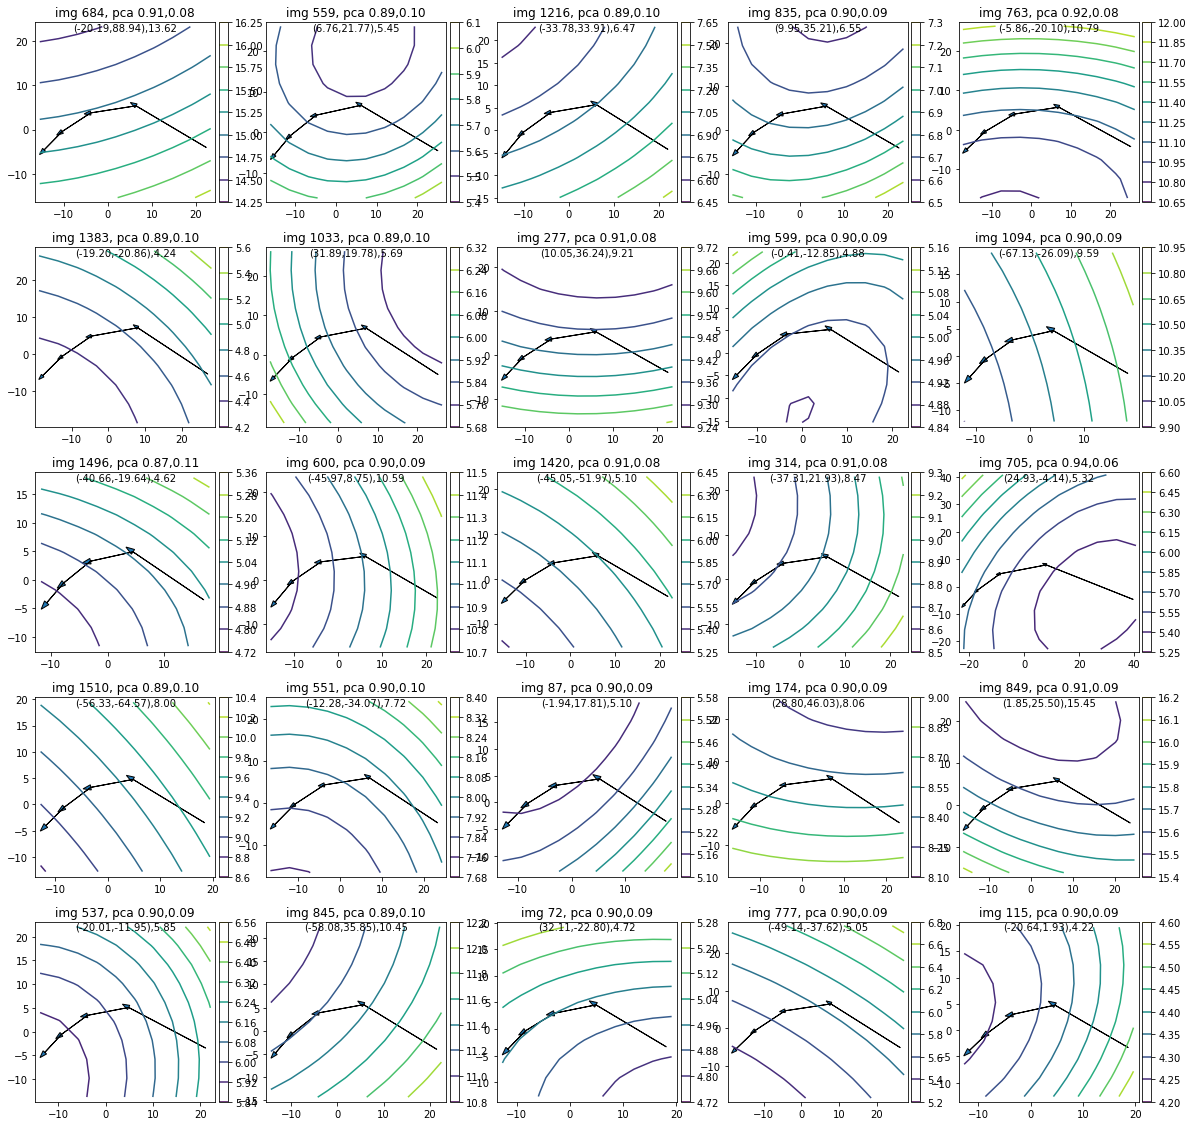

diff_overall                [0.2316972315311432, 0.11892560124397278, 0.08...
diff_per_image_mean         [0.2300156786944717, 0.11813071050215512, 0.08...
diff_per_image_std          [0.019874257536939555, 0.010169494794910708, 0...
corr_test                                                            0.676682
h5file                      /home/yimengzh/thesis-v2-large-files/maskcnn_p...
key_for_training_result     yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_...
mean_diff_overall                                                    0.125838
mean_diff_per_image                                                  0.125071
mean_diff_overall_first4                                             0.125838
Name: (5120, relu, poisson, 0.01, 5e-06, 3, 32, False), dtype: object
0.016885523
[15.61381689 14.78071916 14.73837457 15.74841104 15.95576737] [15.6444952  14.64146666 14.98161592 15.54135831 15.98440673]
0.01020854980083477
0.018417433
[4.81608293 4.67506058 4.43957823 4.31707286 4.20924357] [4.

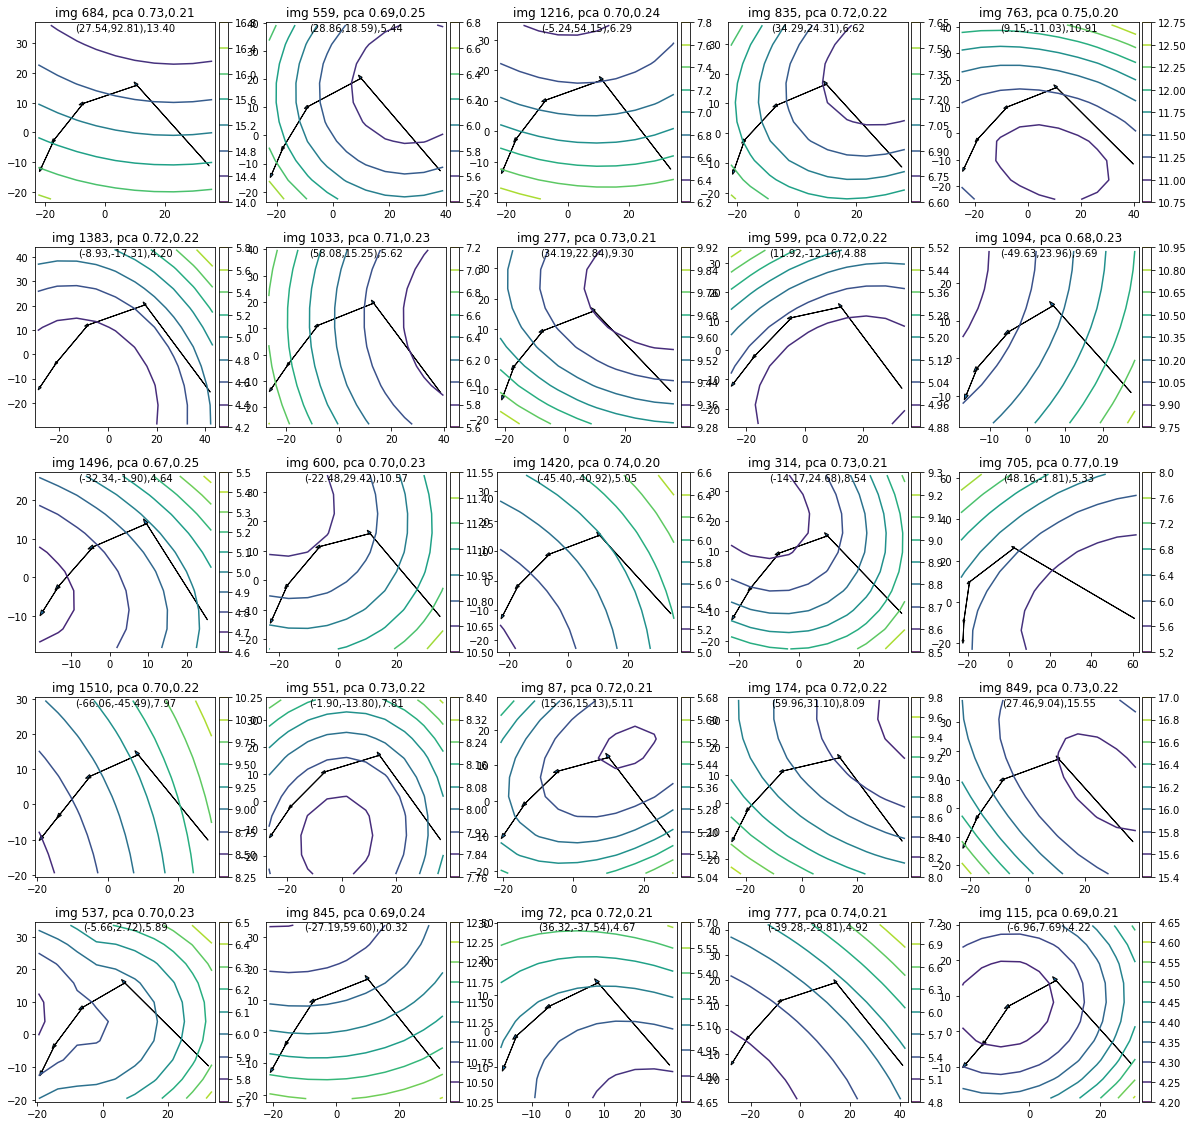

In [38]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 0, y_test=global_datasets['y_test'])
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 0, False, y_test=global_datasets['y_test'])